# データ整形
df：  
yt → 観測値  
nan_flags → 欠損値なしは0、ありは1  
その他、使用する変数を格納  

## blsallfood.csvの読み込み

In [4]:
import pandas as pd

df = pd.read_csv(r"C:\asp\state_space_model\blsallfood.csv")

In [5]:
df

,yt
0,1720
1,1702
2,1707
3,1708
4,1727
...,...
151,1829
152,1835
153,1782
154,1736


In [6]:
any_na = df['yt'].isna().any()
if any_na:
    print("`yt` 列には欠損値が存在します。")
else:
    print("`yt` 列には欠損値は存在しません。")

`yt` 列には欠損値は存在しません。


## dfの整形

In [7]:
df['nan_flags'] = 0

df

,yt,nan_flags
0,1720,0
1,1702,0
2,1707,0
3,1708,0
4,1727,0
...,...,...
151,1829,0
152,1835,0
153,1782,0
154,1736,0


## dfの各列をseriesに変換

In [8]:
series_y = df['yt']
series_nan_flags = df['nan_flags']

In [9]:
series_y

0      1720
1      1702
2      1707
3      1708
4      1727
       ... 
151    1829
152    1835
153    1782
154    1736
155    1706
Name: yt, Length: 156, dtype: int64

In [10]:
series_nan_flags

0      0
1      0
2      0
3      0
4      0
      ..
151    0
152    0
153    0
154    0
155    0
Name: nan_flags, Length: 156, dtype: int64

# 長期予測の検証

In [11]:
import numpy as np

In [12]:
def KF_func(t, series_y, F, G, Q, H, R, I, x_t_1_t_1, V_t_1_t_1, series_nan_flags, sta, end, end_pred):

    # F_t, G_t, Q_t, H_t, R_t の定義(時刻tについての行列)
    F_t = F.copy()
    G_t = G.copy()
    Q_t = Q.copy()
    H_t = H.copy()
    R_t = R.copy()

    # 1期先予測
    x_t_t_1 = F_t @ x_t_1_t_1
    V_t_t_1 = F_t @ V_t_1_t_1 @ F_t.T + G_t @ Q_t @ G_t.T

    # フィルタ
    ## 欠損値なし
    if series_nan_flags[t] == 0:
        d_t_t_1 = H_t @ V_t_t_1 @ H_t.T + R_t  # 対数尤度の計算で使用される
        K_t = V_t_t_1 @ H_t.T @ np.linalg.inv(d_t_t_1)
        x_t_t = x_t_t_1 + K_t @ ((series_y[t] - series_y[sta:end].mean()) - H_t @ x_t_t_1)
        V_t_t = (I - K_t @ H_t) @ V_t_t_1
    ## 欠損値あり
    else:
        d_t_t_1 = None  # 対数尤度の計算で使用される（欠損値がある場合についてはスキップしなければならない）
        K_t = None
        x_t_t = x_t_t_1
        V_t_t = V_t_t_1
    ## 予測誤差の算出(予測時のみ→d_t_j_t ** (1/2)、それ以外はNoneを返す)
    if end <= t < end_pred:
        d_t_j_t = H_t @ V_t_t_1 @ H_t.T + R_t
        root_d_t_j_t = d_t_j_t ** (1/2)
    else:
        d_t_j_t = None
        root_d_t_j_t = None

    # 予測値yの算出
    ## y_t_t_1
    y_t_t_1 = H_t @ x_t_t_1 + series_y[sta:end].mean()

    ## y_t_t
    y_t_t = H_t @ x_t_t + series_y[sta:end].mean()

    return x_t_t_1, V_t_t_1, d_t_t_1, K_t, x_t_t, V_t_t, y_t_t_1, y_t_t, root_d_t_j_t

In [13]:
def loglike_func(series_y, series_nan_flags):
    # 行列の定義(F, G, Q, H, I)
    ##  F：推移行列(15 * 15)
    F = np.zeros([15, 15])
    F[0, :] = [
        1.13164633, -0.13384263, -0.25397419, 0.02039985,0.03500777,
        0.05990097, -0.17683803, 0.08439510, 0.10236195, -0.12517702,
        0.10852823, 0.64089953, -0.74428281, 0.04803834, 0.15332373
        ]
    for i in range(1, 15):
        F[i, i - 1] = 1

    ## G：(15 * 1)
    G = np.zeros([15, 1])
    G[0, 0] = 1

    ## Q：システムノイズの分散(1 * 1)
    Q = np.identity(1) * 422.747668985944

    ## H：観測行列(1 * 15)
    H = np.zeros([1, 15])
    H[0, 0] = 1

    ## I：単位行列(15 * 15)
    I = np.identity(15)

    ## R：観測ノイズの分散共分散行列(1*1) → 尤度を計算する際には R = 1 で設定される。
    R = np.identity(1)

    # 初期値の定義
    ## x_0_0：初期状態(15 * 1)
    x_0_0 = np.zeros([15, 1])

    ## V_0_0：初期分散共分散行列(15 * 15)
    V_0_0 = np.identity(15)
    V_0_0 = V_0_0 * 1e5

    # staとendの定義
    sta = 0
    end = 120  ### 使用するデータ数を定義
    end_pred = 156  ### 予測終了時点を定義

    # カルマンフィルタの計算
    ## トレーニングデータの取得
    y_train = series_y[sta:end]
    nan_flags_train = series_nan_flags[sta:end]

    ## 予測データの作成
    y_pred = pd.Series(series_y[end - 1], index = range(end, end_pred))
    nan_flags_pred = pd.Series(1, index = range(end, end_pred))

    ## トレーニングデータと予測データのマージ：カルマンフィルタの計算で使用される
    y_t = pd.concat([y_train, y_pred])
    nan_flags_t = pd.concat([nan_flags_train, nan_flags_pred])

    ## t_max：データ長の定義
    t_max = end_pred - sta

    ## カルマンフィルタの結果を格納するリストの定義
    list_x_t_t_1 =[]
    list_V_t_t_1 = []
    list_d_t_t_1_tilde = [] # R=1で計算しているため
    list_K_t = []
    list_x_t_t = []
    list_V_t_t = []
    list_y_t_t_1 = []
    list_y_t_t = []
    list_root_d_t_j_t = []

    ## カルマンフィルタの計算
    for t in range(t_max):
        ### KF_funcの利用
        if t == 0:
            x_t_t_1, V_t_t_1, d_t_t_1_tilde, K_t, x_t_t, V_t_t, y_t_t_1, y_t_t, root_d_t_j_t = KF_func(t, y_t, F, G, Q, H, R, I, x_0_0, V_0_0, nan_flags_t, sta, end, end_pred)
        else:
            x_t_1_t_1 = list_x_t_t[t-1]
            V_t_1_t_1 = list_V_t_t[t-1]
            x_t_t_1, V_t_t_1, d_t_t_1_tilde, K_t, x_t_t, V_t_t, y_t_t_1, y_t_t, root_d_t_j_t = KF_func(t, y_t, F, G, Q, H, R, I, x_t_1_t_1, V_t_1_t_1, nan_flags_t, sta, end, end_pred)
        ### リストに計算結果を挿入
        list_x_t_t_1.append(x_t_t_1)
        list_V_t_t_1.append(V_t_t_1)
        list_d_t_t_1_tilde.append(d_t_t_1_tilde)
        list_K_t.append(K_t)
        list_x_t_t.append(x_t_t)
        list_V_t_t.append(V_t_t)
        list_y_t_t_1.append(y_t_t_1)
        list_y_t_t.append(y_t_t)
        list_root_d_t_j_t.append(root_d_t_j_t)

    # 対数尤度の計算
    ## sigma_hat_squared の計算
    sigma_hat_squared = 0
    T = 0

    for t in range(t_max):
        if list_d_t_t_1_tilde[t] is not None:
            sigma_hat_squared += (y_t[t] - list_y_t_t_1[t][0]) ** 2 / list_d_t_t_1_tilde[t][0][0]
            T += 1

    sigma_hat_squared = sigma_hat_squared / T

    ## 対数尤度の計算
    ### sigma_ln_d_t_t_1_tilde の計算
    sigma_ln_d_t_t_1_tilde = 0

    for t in range(t_max):
        if list_d_t_t_1_tilde[t] is not None:
            sigma_ln_d_t_t_1_tilde += np.log(list_d_t_t_1_tilde[t][0][0])

    ### l_theta_asterisk の計算
    l_theta_asterisk = -0.5 * (T * np.log(2 * np.pi * sigma_hat_squared) + sigma_ln_d_t_t_1_tilde + T)

    # 返り値の定義
    return list_x_t_t_1, list_V_t_t_1, list_d_t_t_1_tilde, list_K_t, list_x_t_t, list_V_t_t, list_y_t_t_1, list_y_t_t, list_root_d_t_j_t, F, G, Q, H, I, R, x_0_0, V_0_0, sta, end, end_pred, l_theta_asterisk

In [14]:
list_x_t_t_1, list_V_t_t_1, list_d_t_t_1_tilde, list_K_t, list_x_t_t, list_V_t_t, list_y_t_t_1, list_y_t_t, list_root_d_t_j_t, F, G, Q, H, I, R, x_0_0, V_0_0, sta, end, end_pred, l_theta_asterisk = loglike_func(series_y, series_nan_flags)

In [15]:
l_theta_asterisk

array([-516.98515652])

## 結果の表示

### series_y_t_tの作成

In [13]:
# list_y_t_tをフラットなリストに変換
y_t_t_flattened_values = [item[0, 0] for item in list_y_t_t]
# Pandas Seriesに変換
series_y_t_t = pd.Series(y_t_t_flattened_values, name="y_t_t")

In [14]:
series_y_t_t

0      1720.000000
1      1702.000000
2      1707.000000
3      1708.000000
4      1727.000000
          ...     
151    1801.348784
152    1794.038918
153    1758.145594
154    1725.706076
155    1692.867012
Name: y_t_t, Length: 156, dtype: float64

### series_root_d_t_j_tの作成

In [15]:
# list_root_d_t_j_tをフラットなリストに変換（Noneを保持）
root_d_t_f_t_flattened_values = [item[0, 0] if item is not None else None for item in list_root_d_t_j_t]
# Pandas Seriesに変換
series_root_d_t_j_t = pd.Series(root_d_t_f_t_flattened_values, name="root_d_t_j_t")

In [16]:
series_root_d_t_j_t

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
151    65.729120
152    65.893883
153    65.986854
154    66.047493
155    66.060899
Name: root_d_t_j_t, Length: 156, dtype: float64

### 原系列の結果：series_y

In [17]:
import matplotlib.pyplot as plt

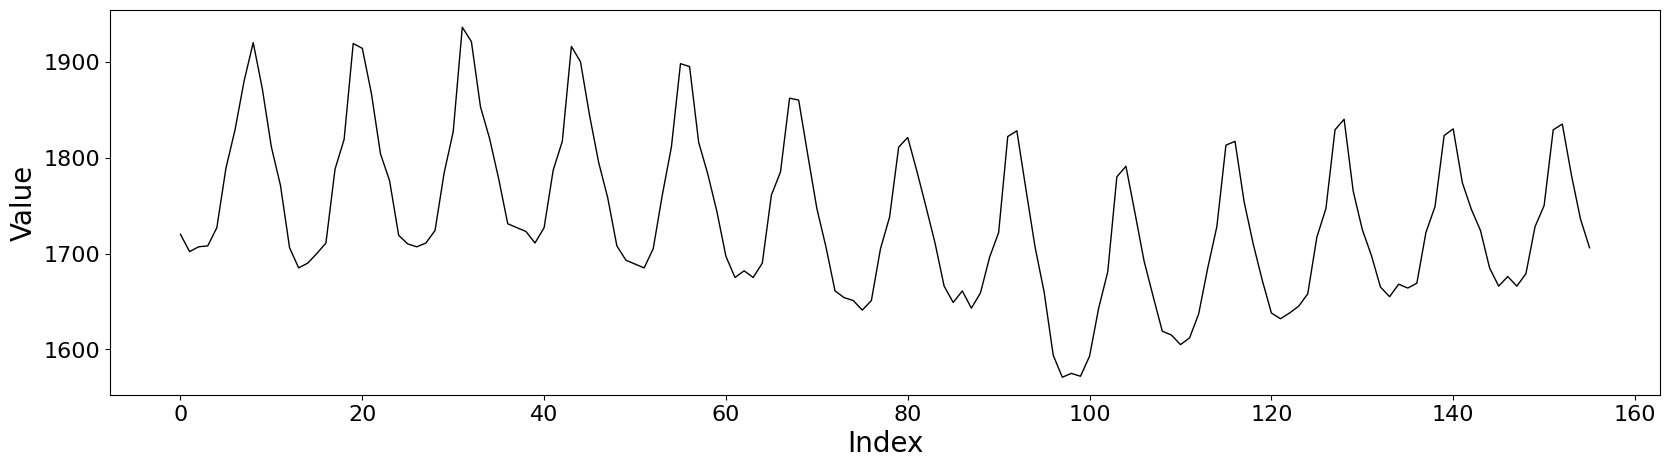

In [18]:
# プロット設定
plt.figure(figsize=(20, 5))  # 図の大きさ
plt.plot(series_y, linestyle='-', color='black', linewidth=1)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Value', fontsize=20)

# 目盛りの文字サイズを変更
plt.tick_params(axis='both', which='major', labelsize=16)  # majorは主目盛り
plt.tick_params(axis='both', which='minor', labelsize=16)  # minorは副目盛り（必要に応じて）

plt.show()

### カルマンフィルタの結果：series_y_t_t

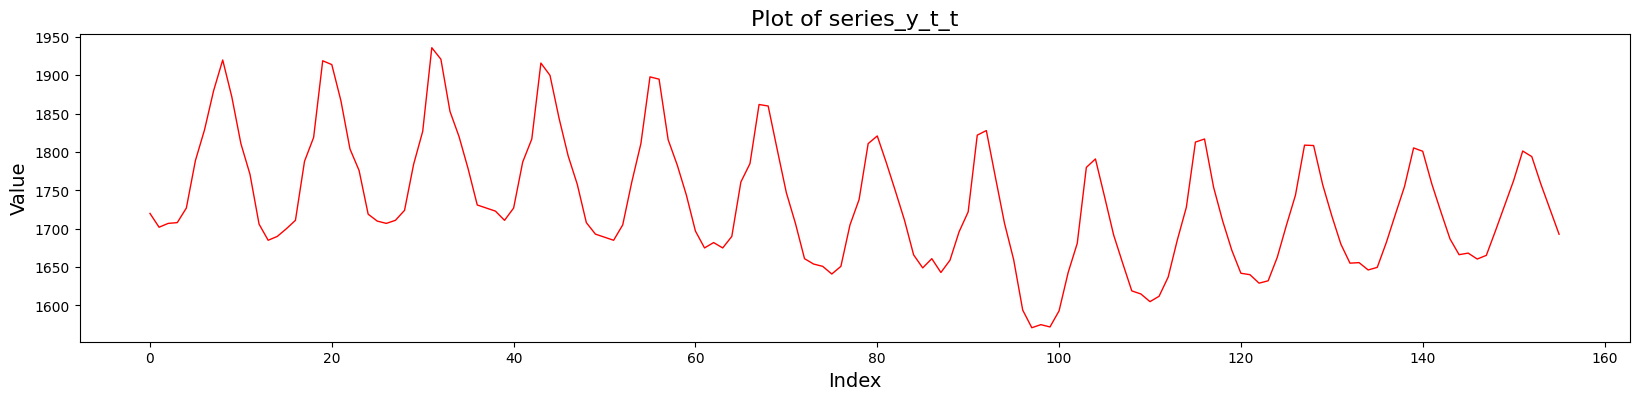

In [19]:
# プロット設定
plt.figure(figsize=(20, 4))  # 図の大きさ
plt.plot(series_y_t_t, linestyle='-', color='red', linewidth=1)  # 黒色の細めの線
plt.title('Plot of series_y_t_t', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.show()

### まとめ

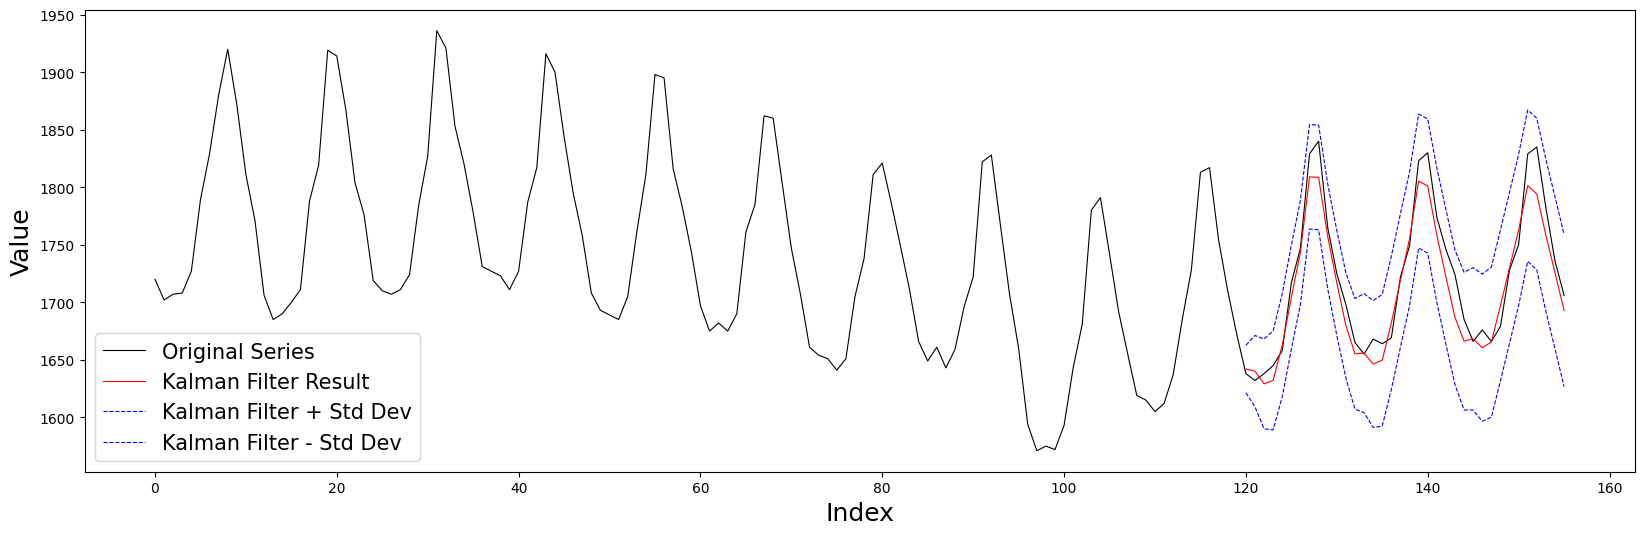

In [20]:
# プロットの描画
plt.figure(figsize=(20, 6))

# 原系列（黒：太さ0.8）
plt.plot(
    range(sta, end_pred),
    series_y[sta:end_pred],
    color='black',
    linewidth=0.8,
    label="Original Series"
)

# カルマンフィルタの結果（赤：太さ0.8）
plt.plot(
    range(end, end_pred),
    series_y_t_t[end:end_pred],
    color='red',
    linewidth=0.8,
    label="Kalman Filter Result"
)

# カルマンフィルタ結果の標準偏差範囲（青：太さ0.8）
plt.plot(
    range(end, end_pred),
    series_y_t_t[end:end_pred] + series_root_d_t_j_t[end:end_pred],
    color='blue',
    linewidth=0.8,
    linestyle='--',
    label="Kalman Filter + Std Dev"
)

plt.plot(
    range(end, end_pred),
    series_y_t_t[end:end_pred] - series_root_d_t_j_t[end:end_pred],
    color='blue',
    linewidth=0.8,
    linestyle='--',
    label="Kalman Filter - Std Dev"
)

# ラベルと凡例
plt.xlabel("Index", fontsize=18)
plt.ylabel("Value", fontsize=18)
plt.legend(fontsize=15)

# グリッドなし
plt.grid(False)

# 描画
plt.show()

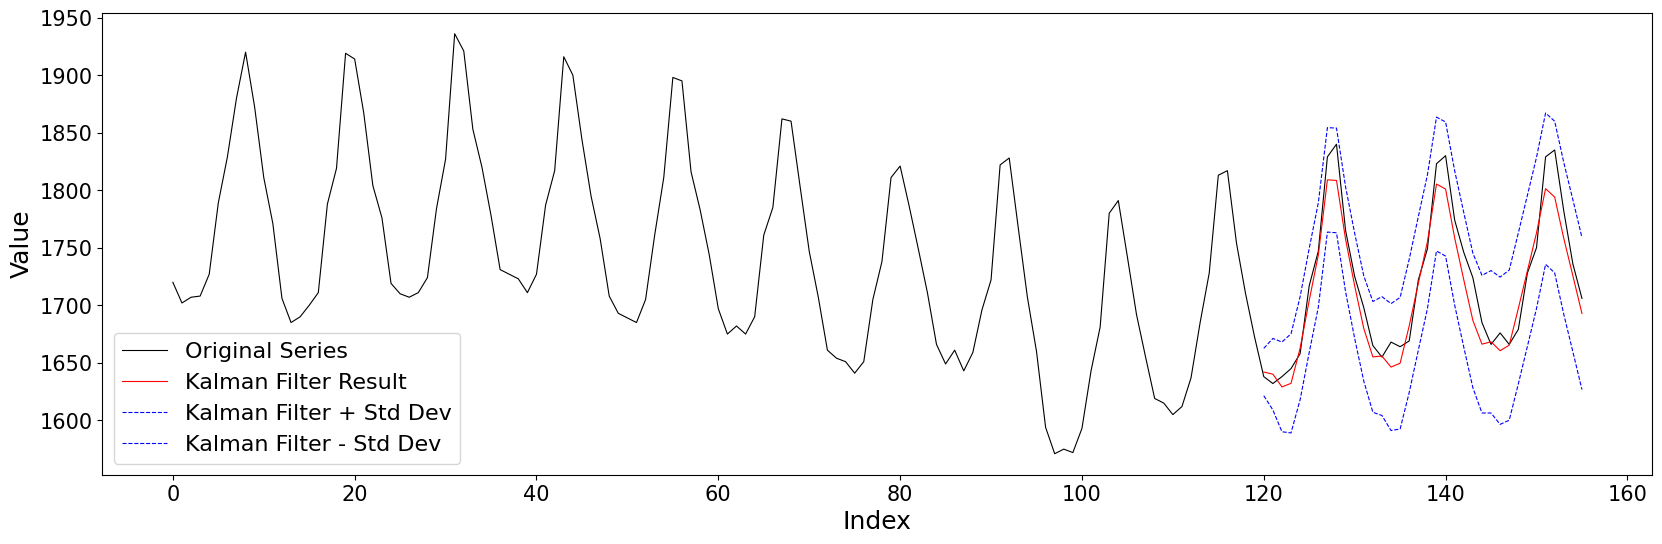

In [21]:
# プロットの描画
plt.figure(figsize=(20, 6))

# 原系列（黒：太さ0.8）
plt.plot(
    range(sta, end_pred),
    series_y[sta:end_pred],
    color='black',
    linewidth=0.8,
    label="Original Series"
)

# カルマンフィルタの結果（赤：太さ0.8）
plt.plot(
    range(end, end_pred),
    series_y_t_t[end:end_pred],
    color='red',
    linewidth=0.8,
    label="Kalman Filter Result"
)

# カルマンフィルタ結果の標準偏差範囲（青：太さ0.8）
plt.plot(
    range(end, end_pred),
    series_y_t_t[end:end_pred] + series_root_d_t_j_t[end:end_pred],
    color='blue',
    linewidth=0.8,
    linestyle='--',
    label="Kalman Filter + Std Dev"
)

plt.plot(
    range(end, end_pred),
    series_y_t_t[end:end_pred] - series_root_d_t_j_t[end:end_pred],
    color='blue',
    linewidth=0.8,
    linestyle='--',
    label="Kalman Filter - Std Dev"
)

# ラベルと凡例
plt.xlabel("Index", fontsize=18)
plt.ylabel("Value", fontsize=18)
plt.legend(fontsize=16)

# 目盛りの文字の大きさを設定
plt.tick_params(axis='both', labelsize=15)

# グリッドなし
plt.grid(False)

# 描画
plt.show()

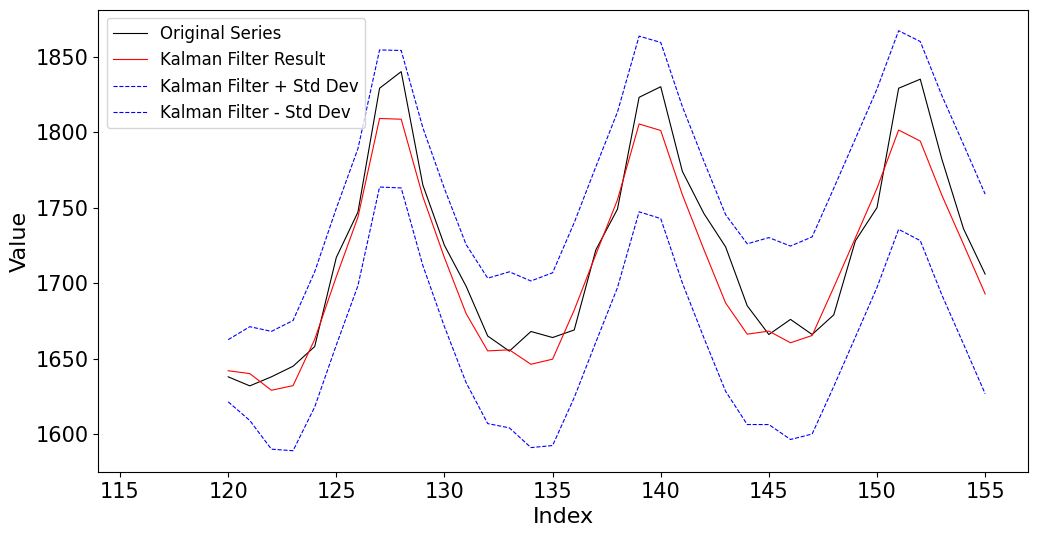

In [22]:
# プロットの描画
plt.figure(figsize=(12, 6))

# 原系列（黒：太さ0.8）
plt.plot(
    range(end, end_pred),
    series_y[end:end_pred],
    color='black',
    linewidth=0.8,
    label="Original Series"
)

# カルマンフィルタの結果（赤：太さ0.8）
plt.plot(
    range(end, end_pred),
    series_y_t_t[end:end_pred],
    color='red',
    linewidth=0.8,
    label="Kalman Filter Result"
)

# カルマンフィルタ結果の標準偏差範囲（青：太さ0.8）
plt.plot(
    range(end, end_pred),
    series_y_t_t[end:end_pred] + series_root_d_t_j_t[end:end_pred],
    color='blue',
    linewidth=0.8,
    linestyle='--',
    label="Kalman Filter + Std Dev"
)

plt.plot(
    range(end, end_pred),
    series_y_t_t[end:end_pred] - series_root_d_t_j_t[end:end_pred],
    color='blue',
    linewidth=0.8,
    linestyle='--',
    label="Kalman Filter - Std Dev"
)

# ラベルと凡例
plt.xlabel("Index", fontsize=16)
plt.ylabel("Value", fontsize=16)
plt.legend(fontsize=12, loc="upper left")

# グリッドなし
plt.grid(False)

# 目盛りの文字の大きさを設定
plt.tick_params(axis='both', labelsize=15)

# x軸の空白を追加
plt.xlim(end - 6, end_pred + 1)

# 描画
plt.show()

### 残差のプロット

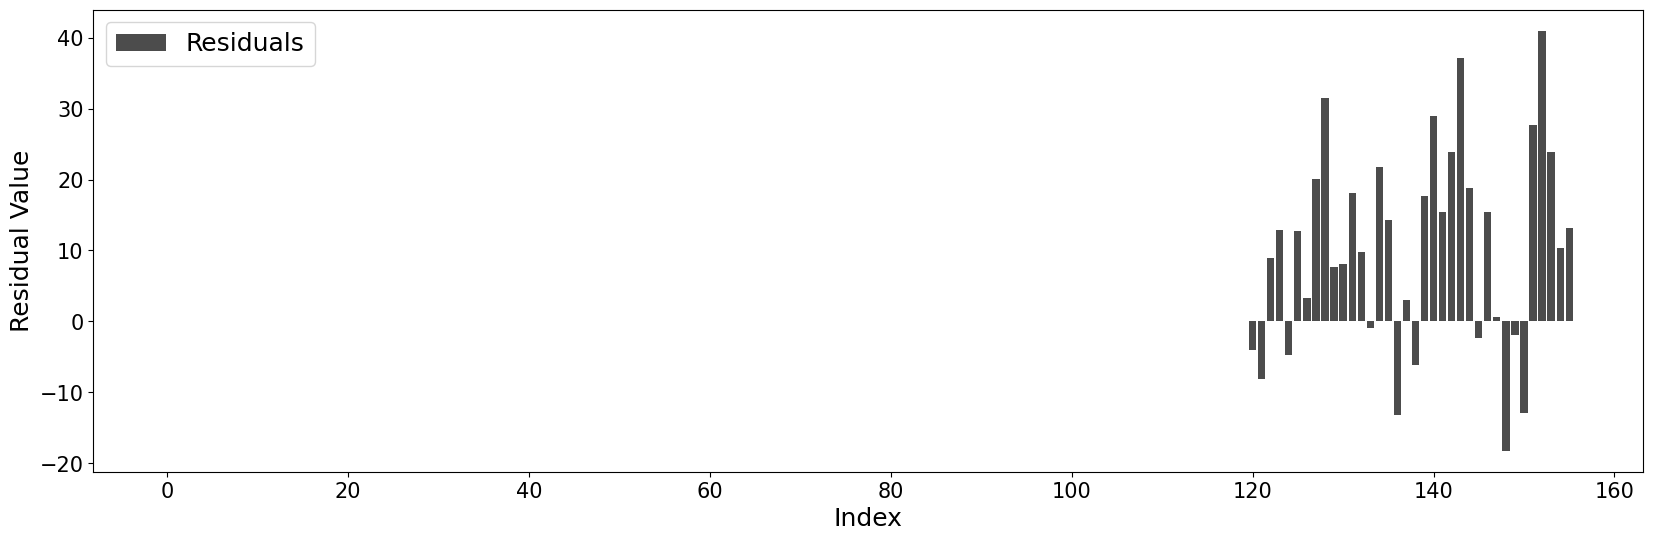

In [23]:
# 残差の計算
residuals = series_y - series_y_t_t  # 原系列とカルマンフィルタの結果の差

# プロットの設定
plt.figure(figsize=(20, 6))
plt.bar(residuals.index, residuals, color="black", alpha=0.7, label="Residuals")

# プロットのタイトルやラベル
plt.xlabel("Index", fontsize=18)
plt.ylabel("Residual Value", fontsize=18)

# 凡例
plt.legend(fontsize=18)

# 目盛りの文字の大きさを設定
plt.tick_params(axis='both', labelsize=15)

# 描画
plt.show()